In [65]:
pip install numpy pandas matplotlib yfinance arch xgboost scikit-learn jupyter

Note: you may need to restart the kernel to use updated packages.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('seaborn-v0_8')


In [67]:
data = yf.download("^GSPC", start="2005-01-01", end="2025-12-31")

[*********************100%***********************]  1 of 1 completed


In [68]:
data.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

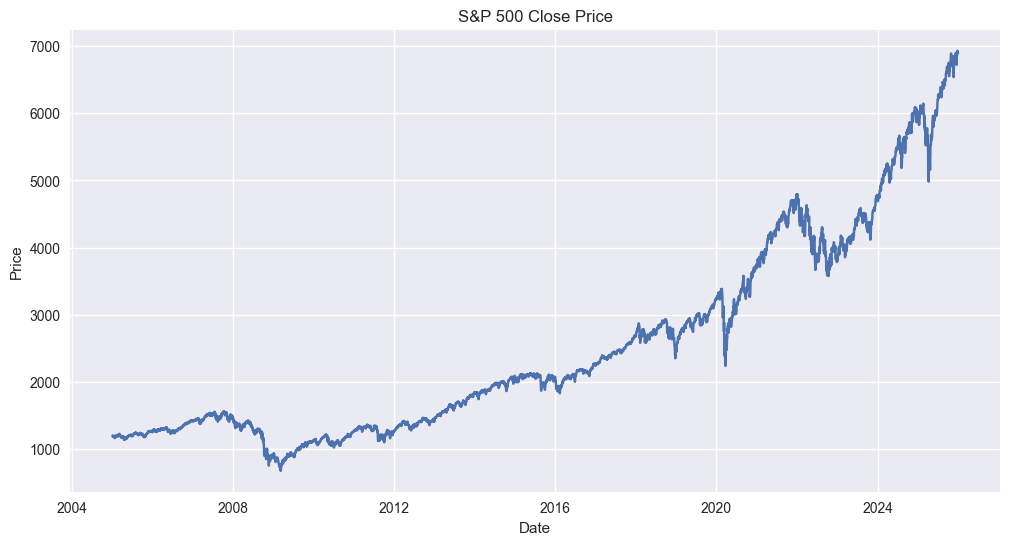

In [69]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title("S&P 500 Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [70]:
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

data = data.dropna()

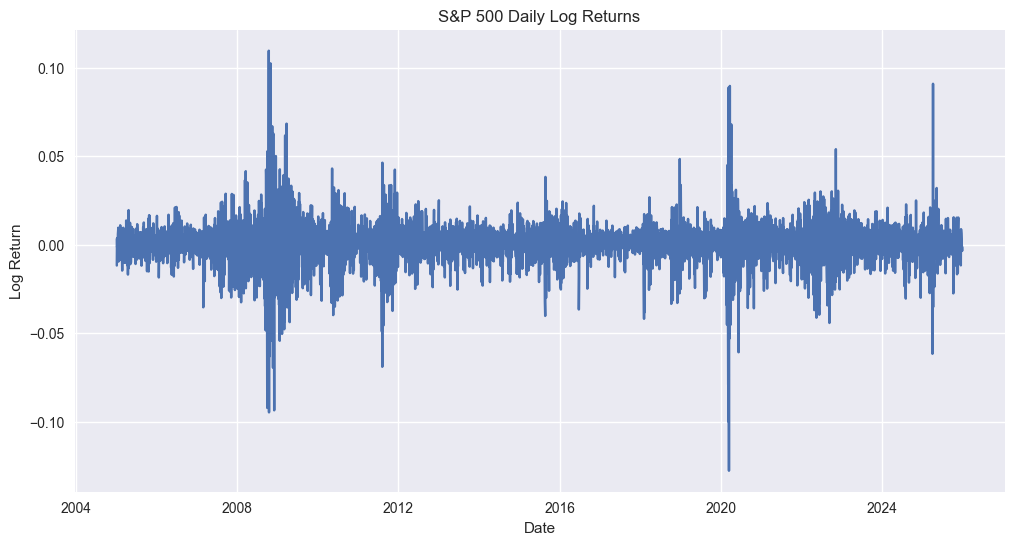

In [71]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Return'])
plt.title("S&P 500 Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


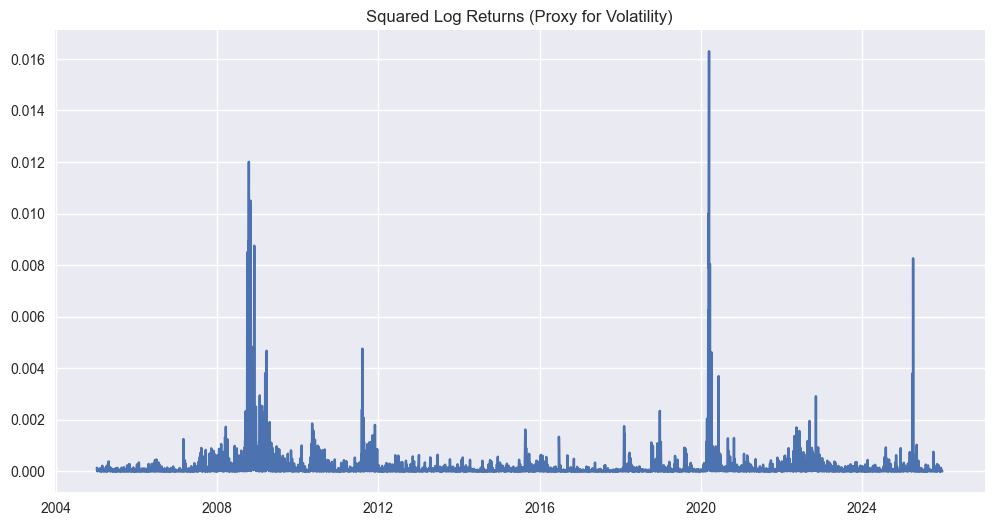

In [72]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Return']**2)
plt.title("Squared Log Returns (Proxy for Volatility)")
plt.show()


In [73]:
# ARCH test for testing autocorrelation between squared returns
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

In [74]:
arch_test = het_arch(data['Log_Return'])

print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])

ARCH Test Statistic: 1489.000293145993
p-value: 0.0


In [75]:
returns = data['Log_Return'] * 100

realized_var = returns ** 2 # we are trying to predict this
split_index = int(len(returns) * 0.8)

train_returns = returns[:split_index]
test_returns = returns[split_index:]

In [76]:
garch_preds = []

for i in range(split_index, len(returns)):
    
    train_data = returns[:i]
    
    model = arch_model(train_data, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    
    forecast = result.forecast(horizon=1)
    garch_preds.append(forecast.variance.values[-1, 0])

garch_var_pred = pd.Series(garch_preds, index=test_returns.index)


In [77]:
# XGBoost Feature Engineering
df_ml = pd.DataFrame(index=returns.index)
df_ml['Target_Var'] = realized_var

df_ml['Lag_Return'] = returns.shift(1)
df_ml['Lag_Var'] = realized_var.shift(1)
df_ml['Rolling_Var_5'] = realized_var.shift(1).rolling(5).mean()
df_ml['Rolling_Var_21'] = realized_var.shift(1).rolling(21).mean()
df_ml['Lag_Abs_Ret'] = np.abs(returns).shift(1)

df_ml['Negative_Ret_Lag'] = (returns.shift(1) < 0).astype(int) * realized_var.shift(1)
df_ml = df_ml.dropna()

In [78]:
train_ml = df_ml.iloc[:split_index]
test_ml = df_ml.iloc[split_index:]

X_train = train_ml.drop(columns=['Target_Var'])
y_train = train_ml['Target_Var']
X_test = test_ml.drop(columns=['Target_Var'])
y_test = test_ml['Target_Var']

In [79]:
from xgboost import XGBRegressor

xgb_vol = XGBRegressor(
    n_estimators=500,
    max_depth=3, # Shorter trees are better for noisy financial data
    learning_rate=0.01,
    early_stopping_rounds=20,
    random_state=42
)

xgb_vol.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_var_pred = pd.Series(xgb_vol.predict(X_test), index=y_test.index)

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

--- GARCH(1,1) Results ---
MSE: 12.1498
MAE: 1.3511
QLIKE: 0.9923

--- XGBoost Results ---
MSE: 11.6402
MAE: 1.4349
QLIKE: 1.0538


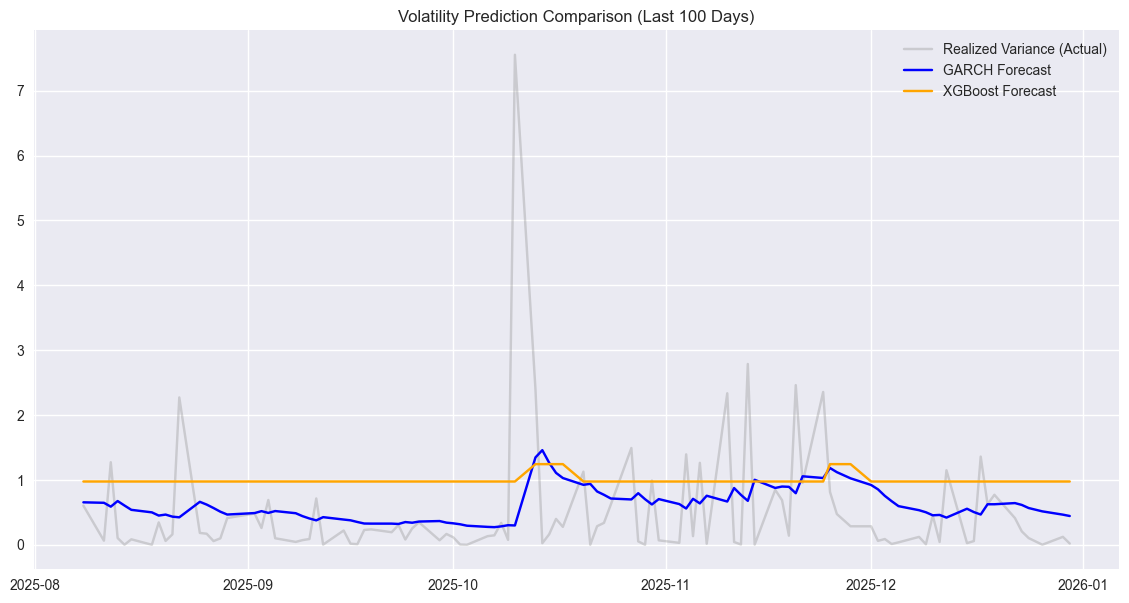

In [81]:
def calculate_qlike(realized, predicted):
    predicted = np.maximum(predicted, 1e-6)
    return np.mean(np.log(predicted) + (realized / predicted))

# Align indices for final metrics
common_index = garch_var_pred.index.intersection(xgb_var_pred.index)
y_true = realized_var.loc[common_index]

print("--- GARCH(1,1) Results ---")
print(f"MSE: {mean_squared_error(y_true, garch_var_pred.loc[common_index]):.4f}")
print(f"MAE: {mean_absolute_error(y_true, garch_var_pred.loc[common_index]):.4f}")
print(f"QLIKE: {calculate_qlike(y_true, garch_var_pred.loc[common_index]):.4f}")

print("\n--- XGBoost Results ---")
print(f"MSE: {mean_squared_error(y_true, xgb_var_pred.loc[common_index]):.4f}")
print(f"MAE: {mean_absolute_error(y_true, xgb_var_pred.loc[common_index]):.4f}")
print(f"QLIKE: {calculate_qlike(y_true, xgb_var_pred.loc[common_index]):.4f}")

# 6. Visualization
plt.figure(figsize=(14, 7))
plt.plot(y_true.tail(100), label='Realized Variance (Actual)', color='gray', alpha=0.3)
plt.plot(garch_var_pred.loc[common_index].tail(100), label='GARCH Forecast', color='blue')
plt.plot(xgb_var_pred.loc[common_index].tail(100), label='XGBoost Forecast', color='orange')
plt.title("Volatility Prediction Comparison (Last 100 Days)")
plt.legend()
plt.show()

<>:101: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:101: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/pd/rq8p8b214xs8qh2ltrzn3xrc0000gn/T/ipykernel_16097/2994462777.py:101: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  plt.ylabel("Variance ($\sigma^2$)")
[*********************100%***********************]  1 of 1 completed



--- PERFORMANCE COMPARISON ---
[GARCH (1,1,1)] MSE: 11.0239 | MAE: 0.9775 | QLIKE: 0.6418
[Hybrid GARCH-XGBoost] MSE: 10.4631 | MAE: 0.9708 | QLIKE: 0.6272


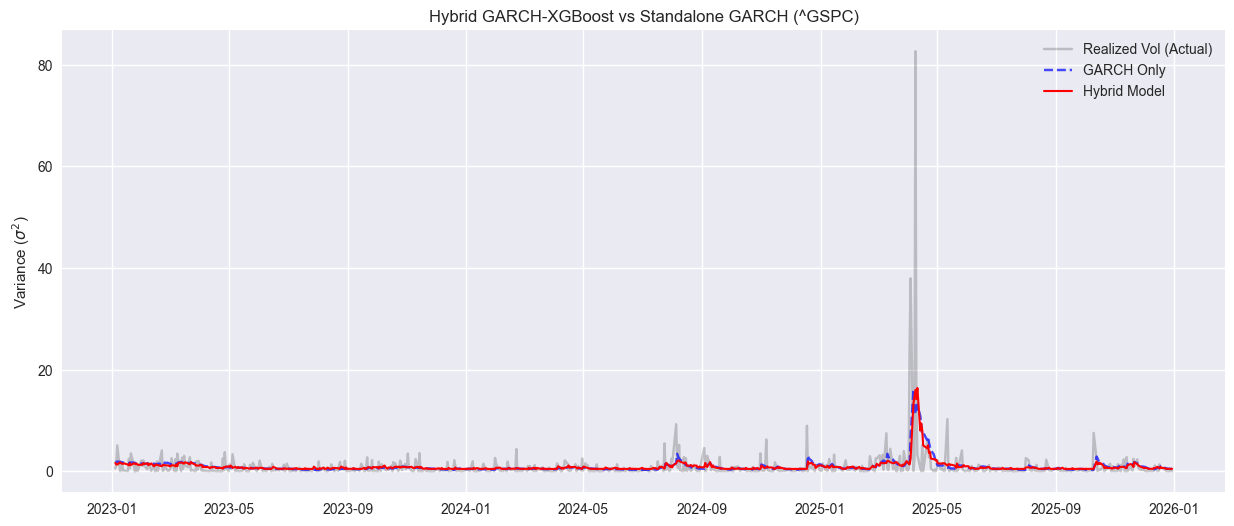

In [ ]:
# hybrid approach

# data
ticker = "^GSPC" # S&P 500
data = yf.download(ticker, start="2010-01-01", end="2025-12-31")
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['Realized_Var'] = (data['Log_Ret'] * 100)**2 # Scale by 100 for stability
data = data.dropna()

returns = data['Log_Ret'] * 100
garch_forecasts = []
window_size = 251 

for i in range(len(returns)):
    if i < window_size:
        garch_forecasts.append(np.nan)
        continue
    
    # Use data up to t-1 to forecast t
    train_slice = returns.iloc[i-window_size:i]
    model = arch_model(train_slice, p=1, q=1, o=1, vol='GARCH', dist='skewt')
    res = model.fit(disp='off', show_warning=False)
    forecast = res.forecast(horizon=1).variance.values[-1, 0]
    garch_forecasts.append(forecast)

data['GARCH_Feat'] = garch_forecasts
data = data.dropna()

# feature engineering
# we used lagged values to prevent data leakage
df_hybrid = pd.DataFrame(index=data.index)
df_hybrid['Target'] = data['Realized_Var']

# GARCH forecast
df_hybrid['GARCH_Base'] = data['GARCH_Feat']

# Parkinson Range (High-Low volatility proxy)
df_hybrid['Lag_HL_Range'] = (np.log(data['High'] / data['Low'])).shift(1)

# Momentum of Volatility
df_hybrid['Lag_Var_5d_Mean'] = data['Realized_Var'].shift(1).rolling(5).mean()
df_hybrid['Lag_Var_21d_Mean'] = data['Realized_Var'].shift(1).rolling(21).mean()

# Returns asymmetry
df_hybrid['Lag_Ret'] = data['Log_Ret'].shift(1)

df_hybrid = df_hybrid.dropna()

# Train/Test Split
split = int(len(df_hybrid) * 0.8)
train, test = df_hybrid.iloc[:split], df_hybrid.iloc[split:]

X_train, y_train = train.drop(columns=['Target']), train['Target']
X_test, y_test = test.drop(columns=['Target']), test['Target']

# XGBoost Training 
model_hybrid = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5, # L2 Regularization to handle noise
    early_stopping_rounds=50,
    random_state=42
)

model_hybrid.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# final prediction
hybrid_preds = model_hybrid.predict(X_test)
garch_only = X_test['GARCH_Base']

# Metrics Calculation
def get_metrics(true, pred, name):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    # QLIKE: Penalizes under-prediction more than over-prediction (ideal for risk)
    qlike = np.mean(np.log(pred) + (true / pred))
    print(f"[{name}] MSE: {mse:.4f} | MAE: {mae:.4f} | QLIKE: {qlike:.4f}")

print("\n--- PERFORMANCE COMPARISON ---")
get_metrics(y_test, garch_only, "GARCH (1,1,1)")
get_metrics(y_test, hybrid_preds, "Hybrid GARCH-XGBoost")

# Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Realized Vol (Actual)', color='black', alpha=0.2)
plt.plot(y_test.index, garch_only, label='GARCH Only', color='blue', linestyle='--', alpha=0.7)
plt.plot(y_test.index, hybrid_preds, label='Hybrid Model', color='red', linewidth=1.5)
plt.title(f"Hybrid GARCH-XGBoost vs Standalone GARCH ({ticker})")
plt.legend()
plt.ylabel("Variance ($\sigma^2$)")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



--- PERFORMANCE SUMMARY ---
Hybrid MSE: 0.0897
GARCH Only MSE: 0.1072


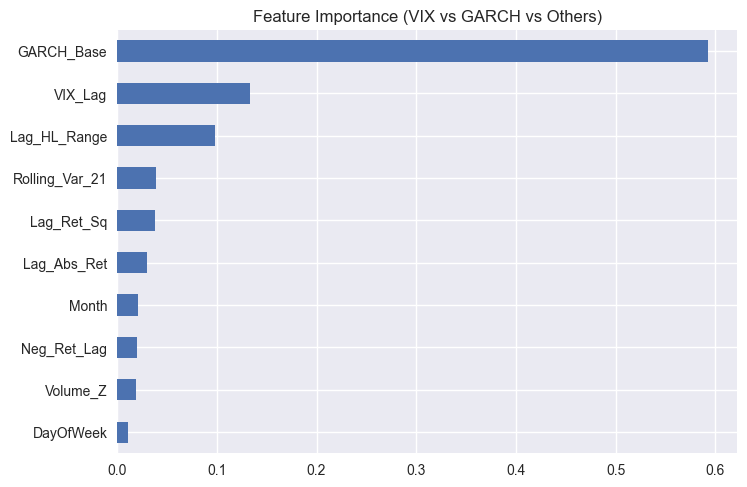

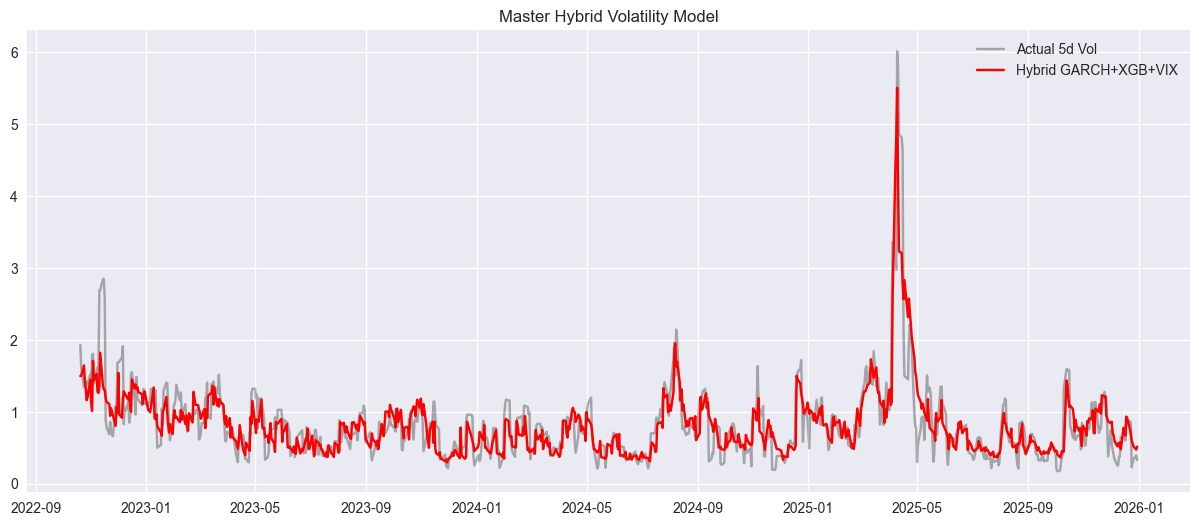

In [83]:
# improved approach

# predicting Rolling volatility (smoother)
# adding Month, DayOfWeek, Quarter as features to capture seasonality
# added VIX (Fear Index)

# VIX is the "Fear Index" - a massive predictor for realized volatility
start_date = "2010-01-01"
end_date = "2025-12-31"

data = yf.download("^GSPC", start=start_date, end=end_date)
vix = yf.download("^VIX", start=start_date, end=end_date)['Close']

# Log Returns & Scaling
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['Realized_Var'] = (data['Log_Ret'] * 100)**2 
# Smooth Target: 5-day Rolling Volatility
data['Target_Vol'] = (data['Log_Ret'] * 100).rolling(5).std()

# Feature Engineering
df = pd.DataFrame(index=data.index)
df['Target'] = data['Target_Vol']

# External Sentiment (VIX)
df['VIX_Lag'] = vix.shift(1) # Must be lagged to avoid leakage

df['Lag_Ret_Sq'] = data['Realized_Var'].shift(1)
df['Lag_Abs_Ret'] = np.abs(data['Log_Ret']).shift(1)
df['Volume_Z'] = ((data['Volume'] - data['Volume'].rolling(21).mean()) / data['Volume'].rolling(21).std()).shift(1)
df['Rolling_Var_21'] = data['Realized_Var'].shift(1).rolling(21).mean()

# Leverage Effect: Higher impact when returns are negative
df['Neg_Ret_Lag'] = (data['Log_Ret'].shift(1) < 0).astype(int) * data['Realized_Var'].shift(1)

# to capture seasonality
df['Lag_HL_Range'] = np.log(data['High'] / data['Low']).shift(1)
df['Month'] = data.index.month
df['DayOfWeek'] = data.index.dayofweek

# GRACH
returns = (data['Log_Ret'] * 100).dropna()
am = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='ged')
res = am.fit(disp='off')
# Match index and add as feature
df['GARCH_Base'] = pd.Series(res.conditional_volatility, index=returns.index)

df = df.dropna()

# Train/Test Split (80/20)
split = int(len(df) * 0.8)
train, test = df.iloc[:split], df.iloc[split:]

X_train, y_train = train.drop(columns=['Target']), train['Target']
X_test, y_test = test.drop(columns=['Target']), test['Target']

# XGBoost Training
model_hybrid = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    early_stopping_rounds=50,
    random_state=42
)

model_hybrid.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

hybrid_preds = model_hybrid.predict(X_test)
garch_only = X_test['GARCH_Base']

print("\n--- PERFORMANCE SUMMARY ---")
print(f"Hybrid MSE: {mean_squared_error(y_test, hybrid_preds):.4f}")
print(f"GARCH Only MSE: {mean_squared_error(y_test, garch_only):.4f}")

# 6. Feature Importance: See what actually matters
importances = pd.Series(model_hybrid.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance (VIX vs GARCH vs Others)')
plt.show()

# 7. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual 5d Vol', color='black', alpha=0.3)
plt.plot(y_test.index, hybrid_preds, label='Hybrid GARCH+XGB+VIX', color='red')
plt.title("Master Hybrid Volatility Model")
plt.legend()
plt.show()